### 1. Setup AWS Sagemaker and bucket with appropriate role

In [1]:
# %%time
import boto3
import re
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri

role = get_execution_role()

bucket='[BUCKET]' # Set this to your bucket name

training_image = get_image_uri(boto3.Session().region_name, 'image-classification')
# print(training_image)

In [2]:
print(role)

### 2. Prepare dataset 
###### Create an EC2 instance
Perform this step outside the Jupyter notebook and we will be using this EC2 instance to download dogs images from Stanford website and create RecordIO files and then upload them to data lake

First, install needed packages including pip, boto3, mxnet, opencv, im2rec.py

Download images from http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar and untar. The Images folder will have 20580 images. With im2rec the images can be grouped for training, validation and tests.  I used 80% for traninig, 19% for validation and remaining 1% for tests.
The directory now should have 3 training (rec, lst, idx), 3 validation (rec, lst, idx) and 1 test (lst) files.

And for more info on RecordIO see http://mesos.apache.org/documentation/latest/recordio/

### 3. Upload the files to data lake

In [5]:
# Upload the files to datalake and the tests files as well (needed at later time) from ec2.

### 4. Setup hyper parameters

In [6]:
num_layers = 18
image_shape = "3,256,256"
num_training_samples = 16464
num_classes = 120
mini_batch_size =  128
epochs = 6
learning_rate = 0.01
top_k=2
use_pretrained_model = 1

### 5. Built dogs name array from lst file

In [10]:
import pandas as pd
import re

remote_lst = 'dog_train.lst'
local_lst = '/tmp/dogs_train.lst'
s3 = boto3.resource('s3')
s3.Bucket(bucket).download_file('stanford_dogs_2/'+remote_lst, local_lst)

dog_lst = []
with open(local_lst, 'r') as f:
    for line in f:
       dog_lst.append(line.split())

df = pd.DataFrame(dog_lst) ;  

df = df.drop(columns=0, axis=1) # drop first column
df.columns = ['idx', 'dog_name']
df['idx'] = df['idx'].apply(lambda x: int(float(x)))
df['dog_name'] = df['dog_name'].apply(lambda x: re.match(r'\s*n\d+-(.*)\/n\d+.*jpg', x).group(1))
print('df shape: ' + str(df.shape))

df = df.drop_duplicates()
print('Duplicates dropped. df shape: ' + str(df.shape))
print(df.sort_values(by=['idx']).head(10))

['12569', '72.000000', 'n02104365-schipperke/n02104365_6732.jpg']
['2674', '14.000000', 'n02089078-black-and-tan_coonhound/n02089078_1842.jpg']
['10471', '58.000000', 'n02099849-Chesapeake_Bay_retriever/n02099849_4646.jpg']
['5888', '32.000000', 'n02093859-Kerry_blue_terrier/n02093859_2625.jpg']
['15899', '93.000000', 'n02108551-Tibetan_mastiff/n02108551_1700.jpg']
['14869', '87.000000', 'n02107574-Greater_Swiss_Mountain_dog/n02107574_1669.jpg']
['17167', '100.000000', 'n02110627-affenpinscher/n02110627_8154.jpg']
['8219', '45.000000', 'n02097047-miniature_schnauzer/n02097047_1721.jpg']
['11249', '63.000000', 'n02101006-Gordon_setter/n02101006_6152.jpg']
['13611', '79.000000', 'n02105855-Shetland_sheepdog/n02105855_13611.jpg']
df shape: (16464, 2)
Duplicates dropped. df shape: (120, 2)
     idx             dog_name
306    0            Chihuahua
23     1     Japanese_spaniel
132    2          Maltese_dog
251    3             Pekinese
113    4             Shih-Tzu
35     5     Blenheim_s

### 6. Setup Sagemaker

In [120]:
%%time
# Use ml.p2.xlarge instance 

import time
import boto3
from time import gmtime, strftime


s3 = boto3.client('s3')
# create unique job name 
job_name_prefix = 'stanford-dog-image-classification-2'
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
job_name = job_name_prefix + timestamp

training_params = \
{
    # specify the training docker image
    "AlgorithmSpecification": {
        "TrainingImage": training_image,
        "TrainingInputMode": "File"
    },
    "RoleArn": role,
    "OutputDataConfig": {
        "S3OutputPath": 's3://{}/stanford_dogs_2/{}/output'.format(bucket, job_name_prefix)
    },
    "ResourceConfig": {
        "InstanceCount": 1,
        "InstanceType": "ml.p2.xlarge",
        "VolumeSizeInGB": 10
    },
    "TrainingJobName": job_name,
    "HyperParameters": {
        "image_shape": image_shape,
        "num_layers": str(num_layers),
        "num_training_samples": str(num_training_samples),
        "num_classes": str(num_classes),
        "mini_batch_size": str(mini_batch_size),
        "epochs": str(epochs),
        "learning_rate": str(learning_rate),
        "use_pretrained_model": str(use_pretrained_model)
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 3600
    },
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": 's3://{}/stanford_dogs_2/train/'.format(bucket),
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "application/x-recordio",
            "CompressionType": "None"
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": 's3://{}/stanford_dogs_2/validation/'.format(bucket),
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "application/x-recordio",
            "CompressionType": "None"
        }
    ]
}
print('Training job name: {}'.format(job_name))
print('\nInput Data Location: {}'.format(training_params['InputDataConfig'][0]['DataSource']['S3DataSource']))

Training job name: stanford-dog-image-classification-2-2018-07-31-22-31-22

Input Data Location: {'S3DataType': 'S3Prefix', 'S3Uri': 's3://[BUCKET]/stanford_dogs_2/train/', 'S3DataDistributionType': 'FullyReplicated'}
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 3.6 ms


### 7. Create training job

In [121]:
# create the Amazon SageMaker training job and wait
sagemaker = boto3.client(service_name='sagemaker')
sagemaker.create_training_job(**training_params)

status = sagemaker.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
print('Training job current status: {}'.format(status))

try:
    sagemaker.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=job_name)
    training_info = sagemaker.describe_training_job(TrainingJobName=job_name)
    status = training_info['TrainingJobStatus']
    print("Training job ended with status: " + status)
except:
    print('Training failed to start')
    message = sagemaker.describe_training_job(TrainingJobName=job_name)['FailureReason']
    print('Training failed with the following error: {}'.format(message))

Training job current status: InProgress
Training job ended with status: Completed


In [122]:
import json

training_info = sagemaker.describe_training_job(TrainingJobName=job_name)
status = training_info['TrainingJobStatus']
print("Training job ended with status: " + status)
# print(training_info)
print('\ntraining_info:\n' + json.dumps(training_info, indent=4, sort_keys=True, default=str))

Training job ended with status: Completed

training_info:
{
    "AlgorithmSpecification": {
        "TrainingImage": "811284229777.dkr.ecr.us-east-1.amazonaws.com/image-classification:1",
        "TrainingInputMode": "File"
    },
    "CreationTime": "2018-07-31 22:31:33.027000+00:00",
    "HyperParameters": {
        "epochs": "6",
        "image_shape": "3,256,256",
        "learning_rate": "0.01",
        "mini_batch_size": "128",
        "num_classes": "120",
        "num_layers": "18",
        "num_training_samples": "16464",
        "use_pretrained_model": "1"
    },
    "InputDataConfig": [
        {
            "...snipped...": "...yes..."
        }
    ],
    "...more snipping...": "...yes...",
}


### 8. Create model

In [123]:
%%time
# Create Model...

import boto3
from time import gmtime, strftime

sage = boto3.Session().client(service_name='sagemaker') 

timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
model_name="image-classification-model" + timestamp
print(model_name)
info = sage.describe_training_job(TrainingJobName=job_name)
model_data = info['ModelArtifacts']['S3ModelArtifacts']
print(model_data)

hosting_image = get_image_uri(boto3.Session().region_name, 'image-classification')

primary_container = {
    'Image': hosting_image,
    'ModelDataUrl': model_data,
}

create_model_response = sage.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

image-classification-model-2018-07-31-22-55-47
s3://[BUCKET]/stanford_dogs_2/stanford-dog-image-classification-2/output/stanford-dog-image-classification-2-2018-07-31-22-31-22/output/model.tar.gz
arn:aws:sagemaker:us-east-1:[ID]:model/image-classification-model-2018-07-31-22-55-47
CPU times: user 40 ms, sys: 0 ns, total: 40 ms
Wall time: 308 ms


### 9. Create endpoint

In [124]:
# Create endpoint configuration....

from time import gmtime, strftime

timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
endpoint_config_name = job_name_prefix + '-epc-' + timestamp
endpoint_config_response = sage.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType': 'ml.m5.large',  #'ml.p2.xlarge',
        'InitialInstanceCount':1,
        'ModelName':model_name,
        'VariantName':'AllTraffic'}])

print('Endpoint configuration name: {}'.format(endpoint_config_name))
print('Endpoint configuration arn:  {}'.format(endpoint_config_response['EndpointConfigArn']))

Endpoint configuration name: stanford-dog-image-classification-2-epc--2018-07-31-22-56-03
Endpoint configuration arn:  arn:aws:sagemaker:us-east-1:[ID]:endpoint-config/stanford-dog-image-classification-2-epc--2018-07-31-22-56-03


In [125]:
%%time
# Create endpoint....

import time

timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
endpoint_name = job_name_prefix + '-ep-' + timestamp
print('Endpoint name: {}'.format(endpoint_name))

endpoint_params = {
    'EndpointName': endpoint_name,
    'EndpointConfigName': endpoint_config_name,
}
endpoint_response = sagemaker.create_endpoint(**endpoint_params)
print('EndpointArn = {}'.format(endpoint_response['EndpointArn']))

Endpoint name: stanford-dog-image-classification-2-ep--2018-07-31-22-56-23
EndpointArn = arn:aws:sagemaker:us-east-1:[ID]:endpoint/stanford-dog-image-classification-2-ep--2018-07-31-22-56-23
CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 214 ms


In [126]:
# get the status of the endpoint

response = sagemaker.describe_endpoint(EndpointName=endpoint_name)
status = response['EndpointStatus']
print('EndpointStatus = {}'.format(status))
    
try:
    sagemaker.get_waiter('endpoint_in_service').wait(EndpointName=endpoint_name)
finally:
    resp = sagemaker.describe_endpoint(EndpointName=endpoint_name)
    status = resp['EndpointStatus']
    print("Arn: " + resp['EndpointArn'])
    print("Create endpoint ended with status: " + status)

    if status != 'InService':
        message = sagemaker.describe_endpoint(EndpointName=endpoint_name)['FailureReason']
        print('Training failed with the following error: {}'.format(message))
        raise Exception('Endpoint creation did not succeed')

EndpointStatus = Creating
Arn: arn:aws:sagemaker:us-east-1:[ID]:endpoint/stanford-dog-image-classification-2-ep--2018-07-31-22-56-23
Create endpoint ended with status: InService


In [157]:
#-- Redundant
# Create an array of dogs from train or validation list (*.lst) file
# > cp dog_train.lst /tmp/.; cd /tmp ; cut -f2,3 > dog_index_map.txt  # retain only 2nd and 3rd columns 
# > vim dog_index_map.txt  # remove float format :1,$s/\.000000// and then prefix and suffix in 3rd column
#      :1,$s/n02\d\+\-// and then 1,$s/n02\d\+_\d\+.jpg// and save  
# File has 16474 entries (one line for each image)
# > cat dog_index_map.txt | sort | uniq | sort -n | cut -f2 > dog_names.txt
#
# > aws s3 cp dog_test/dog_names.txt  s3://[BUCKET]/stanford_dogs/test/dog_names.txt

#- Read dog-names files and create an array
#- local_file = '/tmp/dog_names.txt'
#- remote_file = 'dog_names.txt'
#- s3 = boto3.resource('s3')
#- s3.Bucket('[BUCKET]').download_file('stanford_dogs_2/test/'+remote_file, local_file)
#- dog_names = None
#- with open(local_file, 'r') as f:
#-     dog_names = f.read().split()
#- print(dog_names)


### dogname array from list/dataframe
print(df.head(10))
print(df.loc[df['idx'] == 5])
#----

   idx                    dog_name
0   72                  schipperke
1   14     black-and-tan_coonhound
2   58    Chesapeake_Bay_retriever
3   32          Kerry_blue_terrier
4   93             Tibetan_mastiff
5   87  Greater_Swiss_Mountain_dog
6  100               affenpinscher
7   45         miniature_schnauzer
8   63               Gordon_setter
9   79           Shetland_sheepdog
    idx          dog_name
35    5  Blenheim_spaniel


### 10. Run tests

In [167]:
# Perform inference....
import boto3
runtime = boto3.Session().client(service_name='runtime.sagemaker')

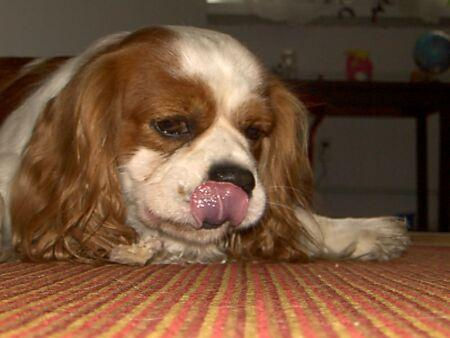

In [186]:
from IPython.display import Image

local_file = '/tmp/test_dog.jpg'
# remote_file = 'Siberian-risky-n02110185_9975.jpg'
# remote_file = 'Images/n02086646-Blenheim_spaniel/n02086646_4045.jpg'       # 99%
# remote_file = 'Images/n02093991-Irish_terrier/n02093991_1635.jpg'          # 69%
# remote_file = 'Images/n02116738-African_hunting_dog/n02116738_9603.jpg'    # 98%
# remote_file = 'Images/n02095314-wire-haired_fox_terrier/n02095314_227.jpg' # 90%
s3 = boto3.resource('s3')
s3.Bucket('[BUCKET]').download_file('stanford_dogs_2/test/'+remote_file, local_file)
Image(local_file)

In [187]:
import json
import numpy as np
with open(local_file, 'rb') as f:
    payload = f.read()
    payload = bytearray(payload)
response = runtime.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType='application/x-image', 
                                   Body=payload)
result = response['Body'].read()
# result will be in json format and convert it to ndarray
result = json.loads(result)
# the result will output the probabilities for all classes
# find the class with maximum probability and print the class index
index = np.argmax(result)
# print('Result: ', '\n'.join([str(x) for x in enumerate(result)]))
print('Index: ', index)
# print("Result: label - " + dog_names[index] + ", probability - " + str(result[index]))
print("Input dog filename - " + remote_file)
print("Identified dog/label - " + df.loc[df['idx'] == index, 'dog_name'].iloc[0]) 
print("Probability - " + str(result[index]))

Index:  5
Input dog filename - Images/n02086646-Blenheim_spaniel/n02086646_4045.jpg
Identified dog/label - Blenheim_spaniel
Probability - 0.9881858825683594


### 11. Delete the stack

In [188]:
sage.delete_endpoint(EndpointName=endpoint_name)

{'ResponseMetadata': {'RequestId': 'b102da36-5da3-4387-92c0-dfae67dafc04',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'b102da36-5da3-4387-92c0-dfae67dafc04',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Wed, 01 Aug 2018 00:24:16 GMT'},
  'RetryAttempts': 0}}